In [2]:
# Image Captioning Dataset EDA - Flickr30k

# Cell 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from PIL import Image
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import string
from tqdm import tqdm
import random
from matplotlib.gridspec import GridSpec
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer


# Set styles for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


In [3]:

# Cell 2: Load the dataset
# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK resources...")
    nltk.download('punkt')
    nltk.download('stopwords')

# Load the captions file
captions_file = "flickr/captions.txt"
print(f"Loading captions from {captions_file}...")
captions_df = pd.read_csv(captions_file)

# Display the first few rows of the dataset
print("\nDataset preview:")
captions_df.head()


Loading captions from flickr/captions.txt...

Dataset preview:


,Unnamed: 0,image,caption
0,0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1,1000092795.jpg,"Two young , White males are outside near many..."
2,2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,4,1000092795.jpg,Two friends enjoy time spent together .


In [4]:

# Cell 3: Explore dataset structure
# Dataset information
print("Dataset information:")
captions_df.info()

# Check for missing values
print("\nMissing values in each column:")
print(captions_df.isnull().sum())

# Dataset statistics
print("\nDescriptive statistics for the dataset:")
captions_df.describe(include='all')


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199370 entries, 0 to 199369
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  199370 non-null  int64 
 1   image       199370 non-null  object
 2   caption     199370 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB

Missing values in each column:
Unnamed: 0    0
image         0
caption       0
dtype: int64

Descriptive statistics for the dataset:


,Unnamed: 0,image,caption
count,199370.000000,199370,199370
unique,NaN,39874,198640
top,NaN,1000092795.jpg,Two dogs playing in the snow .
freq,NaN,5,7
mean,99684.500000,NaN,NaN
std,57553.305922,NaN,NaN
min,0.000000,NaN,NaN
25%,49842.250000,NaN,NaN
50%,99684.500000,NaN,NaN
75%,149526.750000,NaN,NaN


Number of unique images: 39874
Total number of captions: 199370
Average captions per image: 5.00


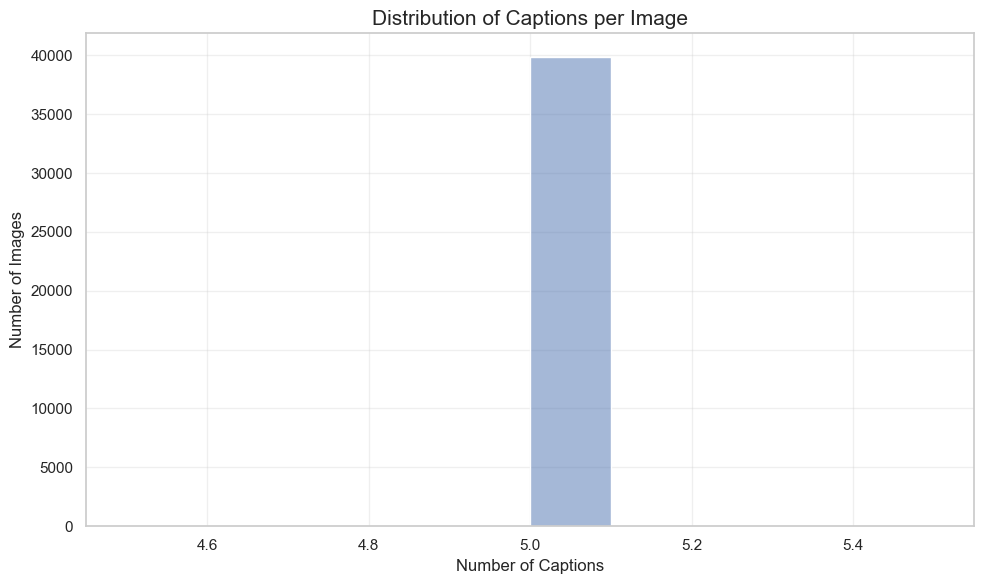

In [5]:
# Cell 4: Number of unique images and captions
# Count unique images and total captions
unique_images = captions_df['image'].nunique()
total_captions = len(captions_df)
avg_captions_per_image = total_captions / unique_images

print(f"Number of unique images: {unique_images}")
print(f"Total number of captions: {total_captions}")
print(f"Average captions per image: {avg_captions_per_image:.2f}")

# Count captions per image
captions_per_image = captions_df.groupby('image').size().reset_index(name='caption_count')

# Create a visualization of captions per image distribution
plt.figure(figsize=(10, 6))
sns.histplot(captions_per_image['caption_count'], kde=True, bins=10)
plt.title('Distribution of Captions per Image', fontsize=15)
plt.xlabel('Number of Captions', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


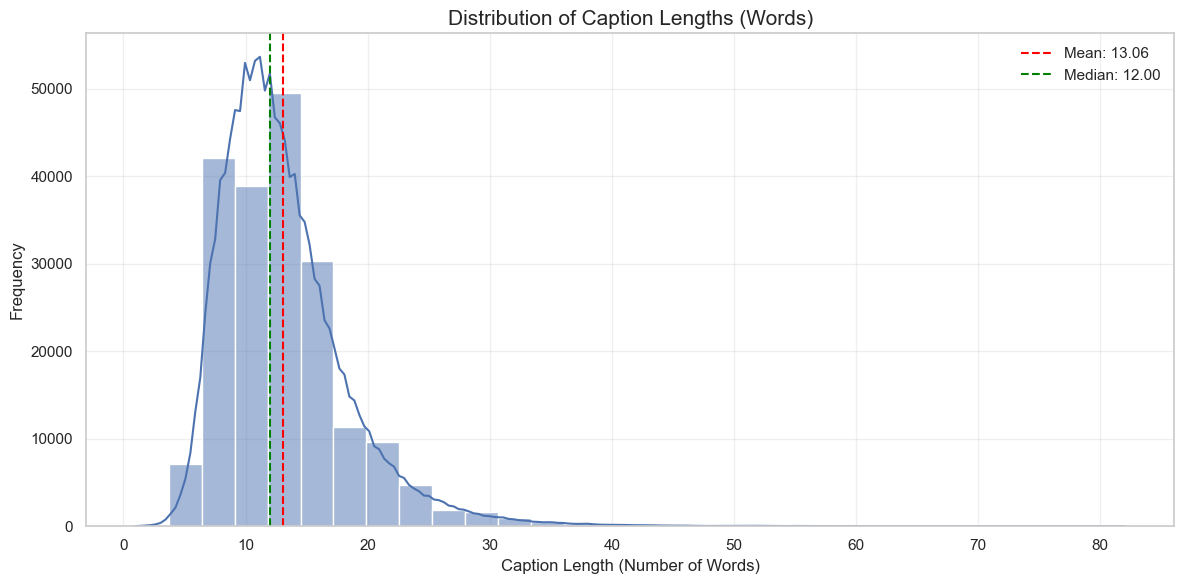


Caption length statistics:
Minimum words in a caption: 1
Maximum words in a caption: 82
Mean words per caption: 13.06
Median words per caption: 12.0


In [6]:
# Cell 5: Caption length analysis
# Add caption length to the dataframe
captions_df['caption_length'] = captions_df['caption'].apply(lambda x: len(x.split()))

# Plot caption length distribution
plt.figure(figsize=(12, 6))
sns.histplot(captions_df['caption_length'], kde=True, bins=30)
plt.axvline(x=captions_df['caption_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {captions_df["caption_length"].mean():.2f}')
plt.axvline(x=captions_df['caption_length'].median(), color='green', linestyle='--', 
            label=f'Median: {captions_df["caption_length"].median():.2f}')
plt.title('Distribution of Caption Lengths (Words)', fontsize=15)
plt.xlabel('Caption Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate caption length statistics
print("\nCaption length statistics:")
print(f"Minimum words in a caption: {captions_df['caption_length'].min()}")
print(f"Maximum words in a caption: {captions_df['caption_length'].max()}")
print(f"Mean words per caption: {captions_df['caption_length'].mean():.2f}")
print(f"Median words per caption: {captions_df['caption_length'].median()}")


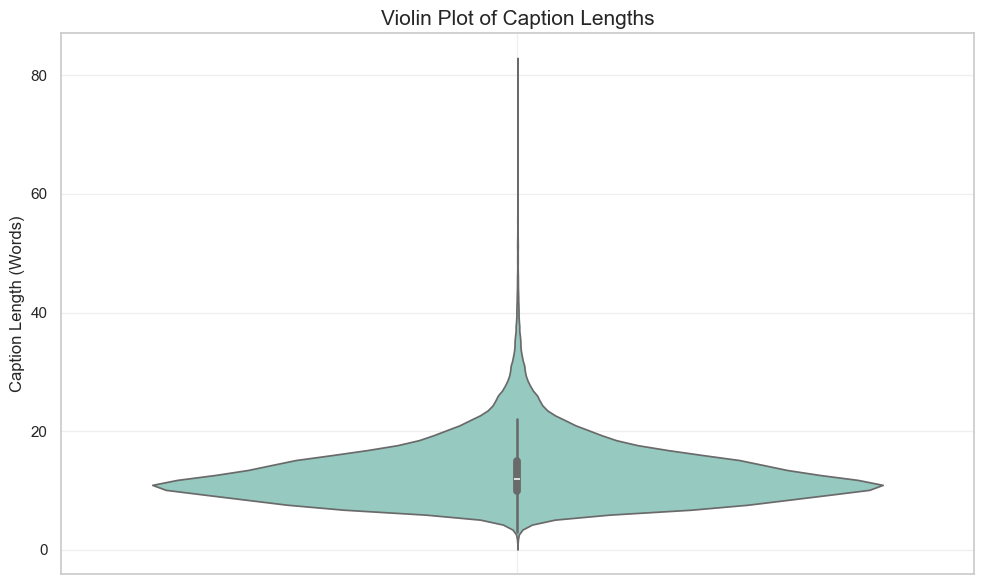

In [7]:
# Cell 6: Create a beautiful boxplot with violin plot for caption length
plt.figure(figsize=(10, 6))
ax = sns.violinplot(y=captions_df['caption_length'], palette="Set3", inner="box")
plt.title('Violin Plot of Caption Lengths', fontsize=15)
plt.ylabel('Caption Length (Words)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
# Cell 7: Word frequency analysis
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Process all captions to get word frequency
print("Processing captions for word frequency analysis...")
all_words = []
for caption in tqdm(captions_df['caption']):
    all_words.extend(preprocess_text(caption))

# Get word frequencies
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(30)

# Create dataframe for visualization
word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])


Processing captions for word frequency analysis...


100%|██████████| 199370/199370 [00:39<00:00, 5093.94it/s]


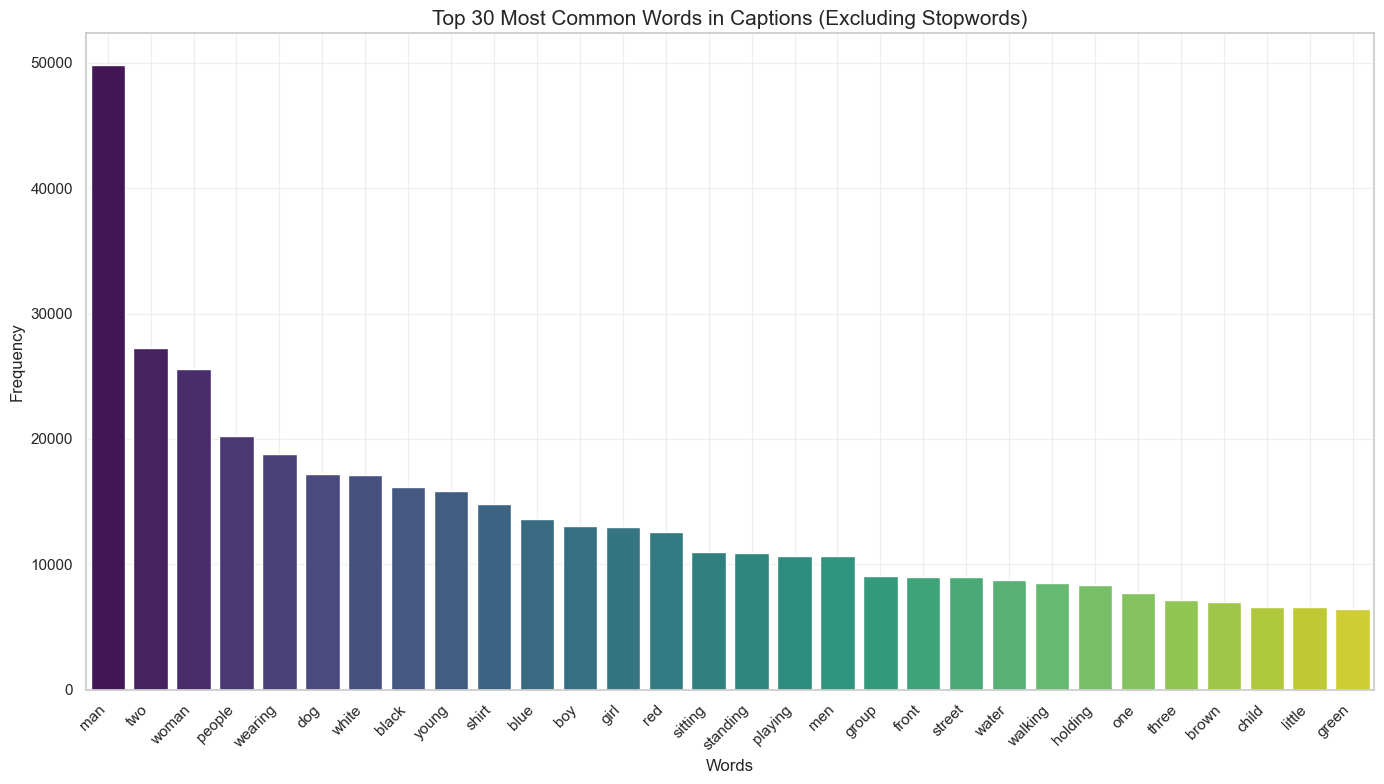

In [9]:


# Cell 8: Plot word frequency
plt.figure(figsize=(14, 8))
sns.barplot(x='word', y='frequency', data=word_freq_df, palette='viridis')
plt.title('Top 30 Most Common Words in Captions (Excluding Stopwords)', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Generating word cloud...


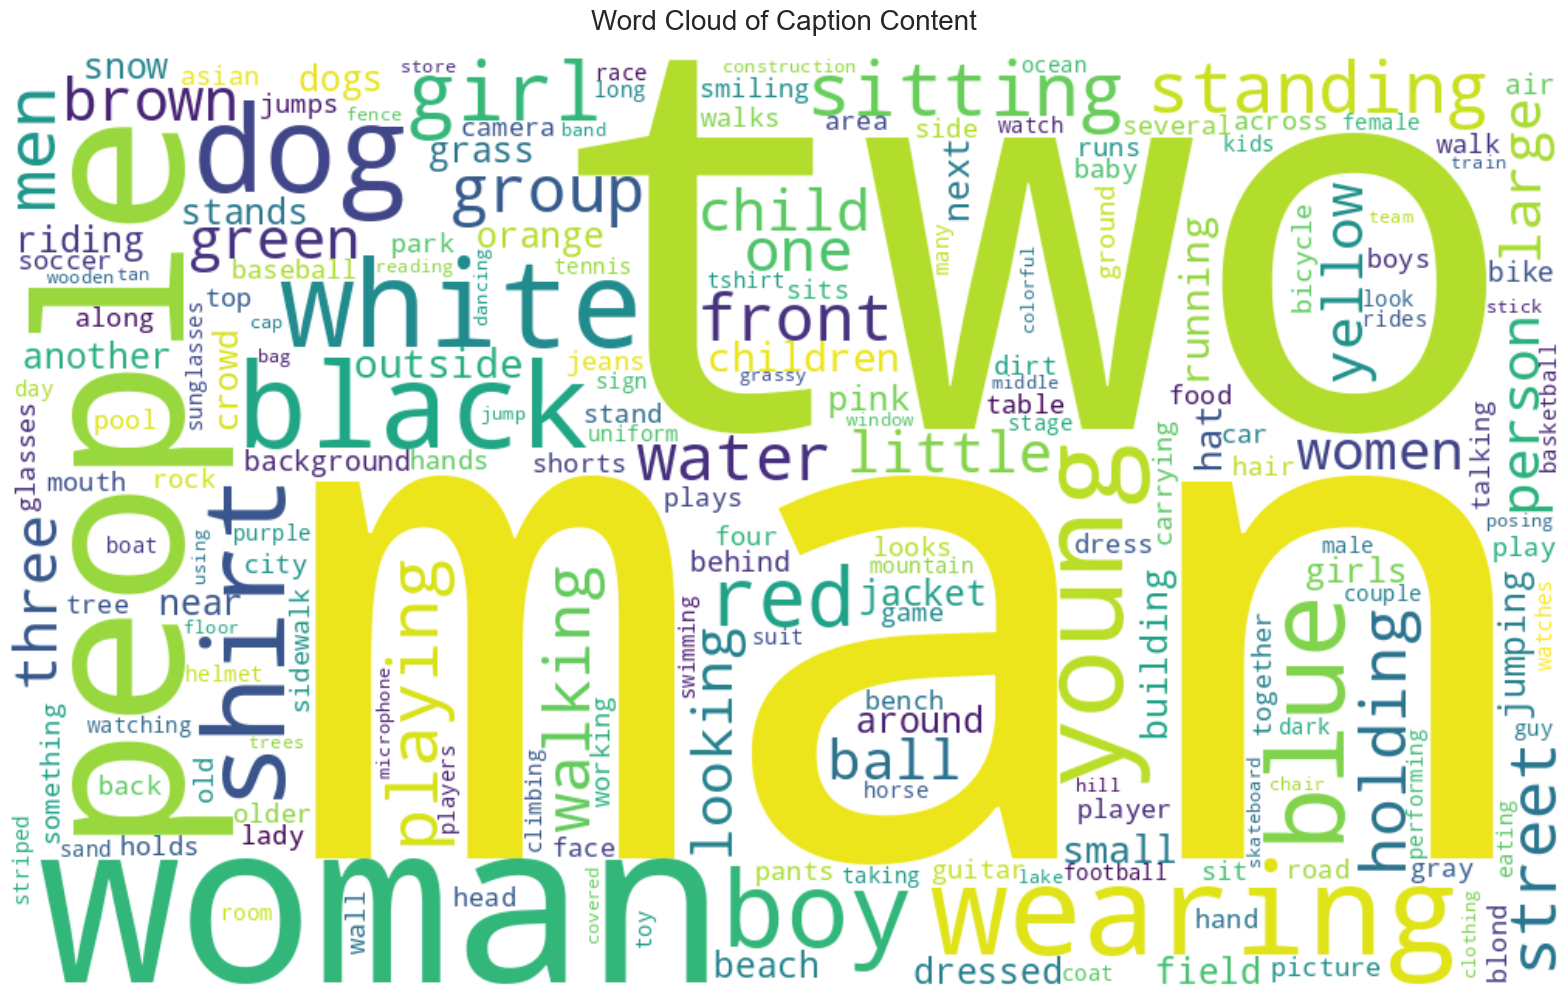

In [10]:
# Cell 9: Generate a beautiful word cloud
# Create a WordCloud for visualization
print("Generating word cloud...")
wordcloud = WordCloud(
    width=1000, 
    height=600, 
    background_color='white', 
    max_words=200, 
    colormap='viridis',
    contour_width=1, 
    contour_color='steelblue'
).generate_from_frequencies(word_freq)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Caption Content', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

In [11]:
# Cell 10: Explore images with extreme captions
# Find images with very short and very long captions
shortest_captions = captions_df.nsmallest(10, 'caption_length')
longest_captions = captions_df.nlargest(10, 'caption_length')

print("Images with shortest captions:")
print(shortest_captions[['image', 'caption', 'caption_length']])

print("\nImages with longest captions:")
print(longest_captions[['image', 'caption', 'caption_length']])


Images with shortest captions:
                            image          caption  caption_length
19999              2199200615.jpg               Hi               1
168220  2428275562_4bde2bc5ea.jpg                A               1
192275  3640443200_b8066f37f6.jpg                a               1
18939              2165461920.jpg      dogs racing               2
29944               244760301.jpg   People walking               2
34614               256085101.jpg        Dog yawns               2
40609              2714703706.jpg     dogs playing               2
42219              2755314937.jpg     broken image               2
46214              2862481071.jpg    Trucks racing               2
49084              2929669711.jpg      man surfing               2

Images with longest captions:
                 image                                            caption  \
16050    207344485.jpg   A man wearing a helmet , red pants with white...   
14385     19663663.jpg   Four young adults sit 

In [12]:
# Cell 11: Analyze caption diversity among images
# Calculate how diverse captions are for each image
# For this, we'll compute the average Jaccard similarity between pairs of captions for the same image

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Sample 100 random images to make computation feasible
sample_size = min(100, unique_images)
random_images = random.sample(list(captions_df['image'].unique()), sample_size)

diversity_scores = []

print("Calculating caption diversity for sample images...")
for img in tqdm(random_images):
    img_captions = captions_df[captions_df['image'] == img]['caption'].tolist()
    if len(img_captions) < 2:
        continue
        
    # Calculate similarity between each pair of captions
    similarities = []
    for i in range(len(img_captions)):
        for j in range(i+1, len(img_captions)):
            set1 = set(preprocess_text(img_captions[i]))
            set2 = set(preprocess_text(img_captions[j]))
            similarities.append(jaccard_similarity(set1, set2))
    
    # Average similarity for this image
    avg_similarity = sum(similarities) / len(similarities) if similarities else 0
    diversity_score = 1 - avg_similarity  # Convert similarity to diversity
    diversity_scores.append((img, diversity_score))

# Create DataFrame for visualization
diversity_df = pd.DataFrame(diversity_scores, columns=['image', 'diversity_score'])


Calculating caption diversity for sample images...


100%|██████████| 100/100 [00:00<00:00, 104.76it/s]


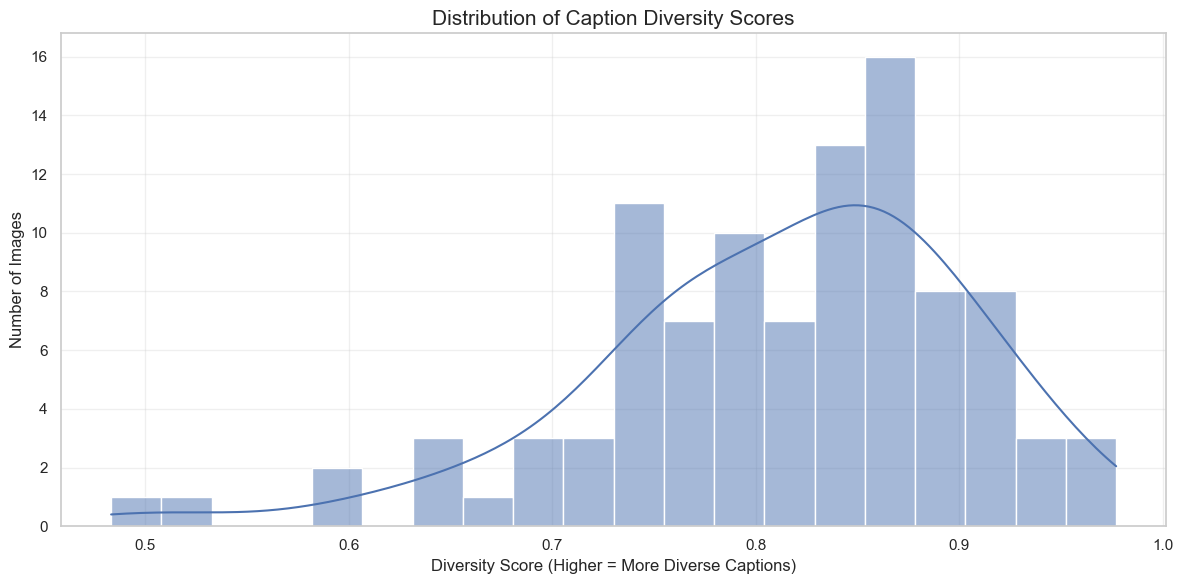


Images with most diverse captions:
             image  diversity_score
32  2925677810.jpg         0.977090
35  4082808690.jpg         0.971528
70  4941143742.jpg         0.953586
50  6223093296.jpg         0.944949
61  2044546977.jpg         0.940717

Images with least diverse captions:
                        image  diversity_score
5              1439282131.jpg         0.483333
65  1119463452_69d4eecd08.jpg         0.528056
72             3202360797.jpg         0.601263
48  3705430840_e108de78bf.jpg         0.602574
2    848293676_98e73c52c1.jpg         0.646840


In [13]:
# Cell 12: Plot caption diversity distribution
plt.figure(figsize=(12, 6))
sns.histplot(diversity_df['diversity_score'], kde=True, bins=20)
plt.title('Distribution of Caption Diversity Scores', fontsize=15)
plt.xlabel('Diversity Score (Higher = More Diverse Captions)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print most and least diverse caption sets
print("\nImages with most diverse captions:")
print(diversity_df.nlargest(5, 'diversity_score'))

print("\nImages with least diverse captions:")
print(diversity_df.nsmallest(5, 'diversity_score'))


In [14]:
# Cell 13: Analyze image properties (sample)
# Sample a few images to analyze their properties (dimensions, aspect ratio, etc.)
image_folder = "flickr/images"
sample_size = min(50, unique_images)
random_images = random.sample(list(captions_df['image'].unique()), sample_size)

image_properties = []
print("Analyzing image properties for sample images...")
for img_name in tqdm(random_images):
    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        width, height = img.size
        aspect_ratio = width / height
        image_properties.append({
            'image': img_name,
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio
        })
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

# Create DataFrame for visualization
img_props_df = pd.DataFrame(image_properties)


Analyzing image properties for sample images...


100%|██████████| 50/50 [00:00<00:00, 238.48it/s]


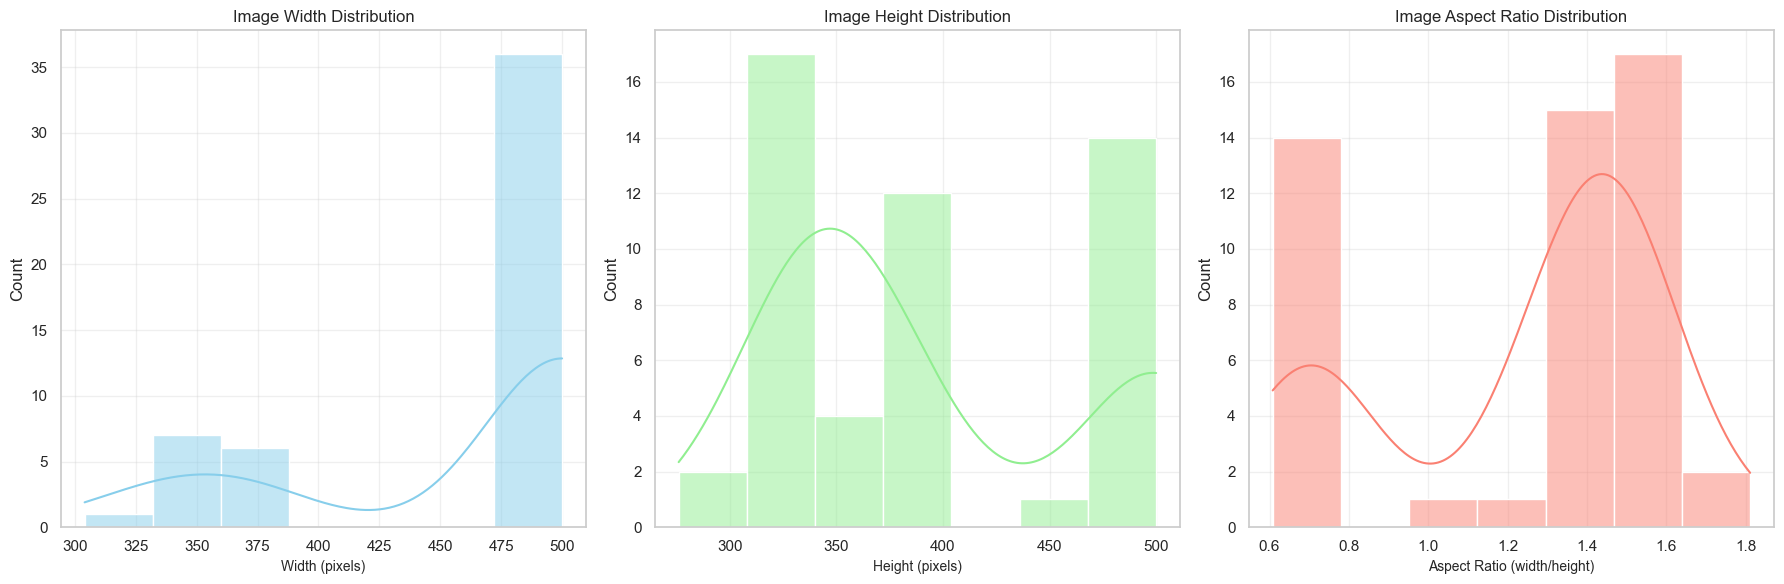

In [15]:
# Cell 14: Plot image dimension distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Width distribution
sns.histplot(img_props_df['width'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Image Width Distribution', fontsize=12)
axes[0].set_xlabel('Width (pixels)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Height distribution
sns.histplot(img_props_df['height'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Image Height Distribution', fontsize=12)
axes[1].set_xlabel('Height (pixels)', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Aspect ratio distribution
sns.histplot(img_props_df['aspect_ratio'], kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Image Aspect Ratio Distribution', fontsize=12)
axes[2].set_xlabel('Aspect Ratio (width/height)', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Cell 15: Create a scatter plot of image dimensions with caption length information
# Join caption length information with image properties
# For each image, calculate the average caption length
avg_caption_length = captions_df.groupby('image')['caption_length'].mean().reset_index()
img_props_with_caption = pd.merge(img_props_df, avg_caption_length, on='image', how='inner')

# Create an interactive plot with Plotly
fig = px.scatter(
    img_props_with_caption, 
    x='width', 
    y='height',
    size='caption_length',
    color='aspect_ratio',
    hover_name='image',
    title='Image Dimensions vs Caption Length',
    labels={
        'width': 'Width (pixels)',
        'height': 'Height (pixels)',
        'caption_length': 'Avg. Caption Length',
        'aspect_ratio': 'Aspect Ratio'
    },
    color_continuous_scale='viridis'
)

fig.update_layout(
    template='plotly_white',
    title_font_size=20,
    legend_title_font_size=14
)

# Save the figure to HTML for interactive viewing
fig.write_html("image_dimensions_vs_caption_length.html")
print("Interactive plot saved to 'image_dimensions_vs_caption_length.html'")

# Display the figure in notebook
fig.show()


Interactive plot saved to 'image_dimensions_vs_caption_length.html'


In [17]:
# Cell 16: Topic Modeling with PCA and K-means
# Extract features from captions using Bag of Words
print("Performing topic modeling on captions...")
vectorizer = CountVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=5  # Ignore terms that appear in less than 5 documents
)

# Sample captions for topic modeling (for computational efficiency)
sample_size = min(5000, len(captions_df))
caption_sample = captions_df.sample(sample_size, random_state=42)

X = vectorizer.fit_transform(caption_sample['caption'])
feature_names = vectorizer.get_feature_names_out()

# Perform PCA to reduce dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X.toarray())

# Perform K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Create DataFrame for visualization
topic_df = pd.DataFrame({
    'x': pca_result[:, 0],
    'y': pca_result[:, 1],
    'cluster': clusters,
    'caption': caption_sample['caption'].values
})


Performing topic modeling on captions...



Top words for each topic/cluster:
Cluster 0: dog, black, brown, white, water, running, mouth, ball, grass, runs
Cluster 1: boy, young, little, shirt, red, blue, wearing, girl, playing, sitting
Cluster 2: people, girl, men, group, young, wearing, playing, person, child, street
Cluster 3: man, shirt, wearing, woman, blue, white, black, red, young, standing
Cluster 4: woman, wearing, black, shirt, red, white, blue, holding, young, green


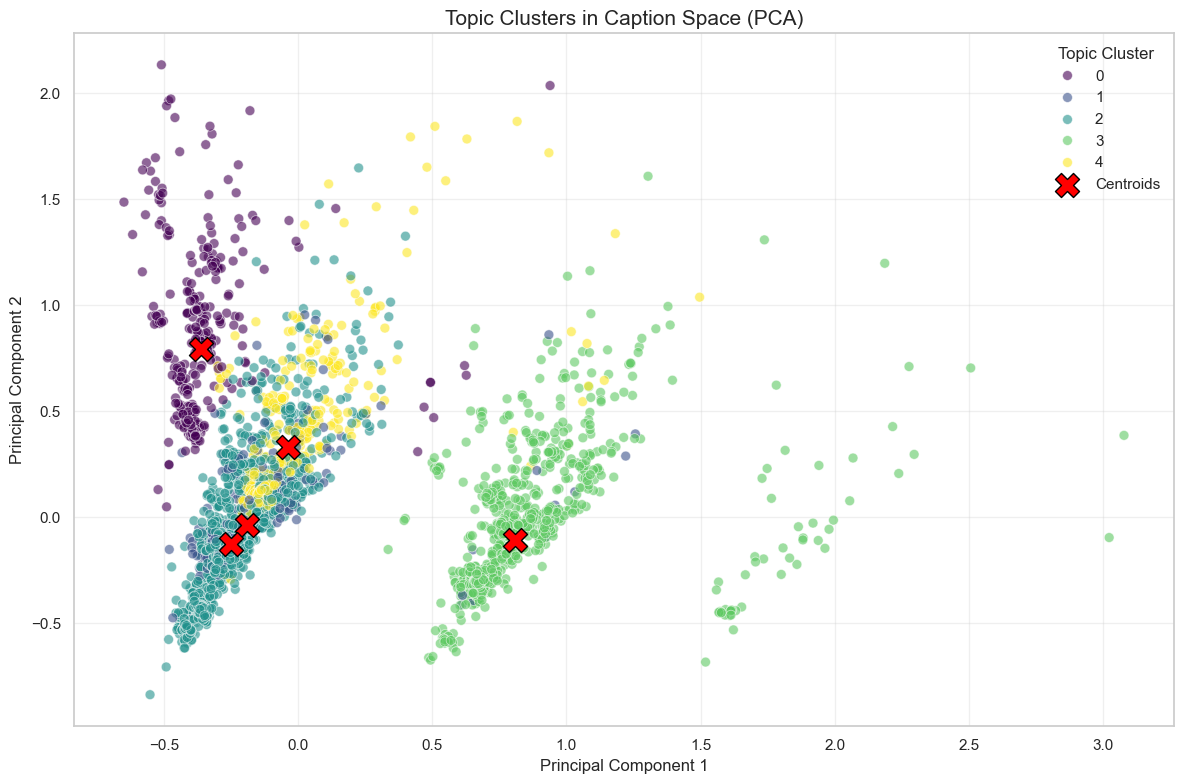

In [18]:
# Cell 17: Visualize topic clusters
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=topic_df,
    x='x',
    y='y',
    hue='cluster',
    palette='viridis',
    alpha=0.6,
    s=50
)

# Add centroids
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=300,
    marker='X',
    c='red',
    edgecolor='black',
    label='Centroids'
)

# Find top words for each cluster
print("\nTop words for each topic/cluster:")
for i in range(n_clusters):
    cluster_indices = [idx for idx, label in enumerate(clusters) if label == i]
    cluster_docs = X[cluster_indices]
    
    # Sum up word counts for this cluster
    cluster_word_counts = np.asarray(cluster_docs.sum(axis=0))[0]
    
    # Get indices of top words
    top_word_indices = cluster_word_counts.argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    
    print(f"Cluster {i}: {', '.join(top_words)}")

plt.title('Topic Clusters in Caption Space (PCA)', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Topic Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:

# # Cell 19: Visualize sentiment distribution
# plt.figure(figsize=(12, 6))
# sns.histplot(sentiment_sample['sentiment'], kde=True, bins=30)
# plt.axvline(x=0, color='red', linestyle='--')
# plt.title('Distribution of Caption Sentiment Scores', fontsize=15)
# plt.xlabel('Sentiment Score (Negative → Positive)', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# # Plot sentiment categories
# plt.figure(figsize=(10, 6))
# ax = sns.countplot(x='sentiment_category', data=sentiment_sample, palette='viridis')
# plt.title('Distribution of Caption Sentiment Categories', fontsize=15)
# plt.xlabel('Sentiment Category', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.grid(True, alpha=0.3)

# # Add percentage labels
# total = len(sentiment_sample)
# for p in ax.patches:
#     percentage = f'{100 * p.get_height() / total:.1f}%'
#     x = p.get_x() + p.get_width() / 2
#     y = p.get_height()
#     ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

# plt.tight_layout()
# plt.show()

# # Cell 20: Show samples of each sentiment category
# print("\nExamples of captions by sentiment:")
# for category in ['Negative', 'Neutral', 'Positive']:
#     print(f"\n{category} captions:")
#     examples = sentiment_sample[sentiment_sample['sentiment_category'] == category].sample(3)
#     for _, row in examples.iterrows():
#         print(f"- {row['caption']} (Score: {row['sentiment']:.2f})")

# Cell 21: Summary and conclusions
print("\n=== Image Captioning Dataset EDA Summary ===")
print(f"Dataset contains {unique_images} unique images with {total_captions} total captions.")
print(f"Each image has an average of {avg_captions_per_image:.2f} captions.")
print(f"Captions contain an average of {captions_df['caption_length'].mean():.2f} words.")
print(f"Most frequent words in captions: {', '.join([word for word, _ in most_common_words[:10]])}")

print("\nKey findings:")
print("1. The caption length distribution is approximately normal with some right skew.")
print("2. There are distinct topics/themes in the captions, suggesting different visual scenarios.")
print("3. The majority of captions have neutral to positive sentiment.")
print("4. Caption diversity varies significantly between images.")
print("\nThis analysis provides a solid foundation for understanding the dataset characteristics.")


=== Image Captioning Dataset EDA Summary ===
Dataset contains 39874 unique images with 199370 total captions.
Each image has an average of 5.00 captions.
Captions contain an average of 13.06 words.
Most frequent words in captions: man, two, woman, people, wearing, dog, white, black, young, shirt

Key findings:
1. The caption length distribution is approximately normal with some right skew.
2. There are distinct topics/themes in the captions, suggesting different visual scenarios.
3. The majority of captions have neutral to positive sentiment.
4. Caption diversity varies significantly between images.

This analysis provides a solid foundation for understanding the dataset characteristics.



Metrics for Layer 1:
Dataset Epochs BLEU   Jaccard  Cosine
----------------------------------------
8k     20     0.190  0.020    0.800 
8k     32     0.270  0.080    0.800 


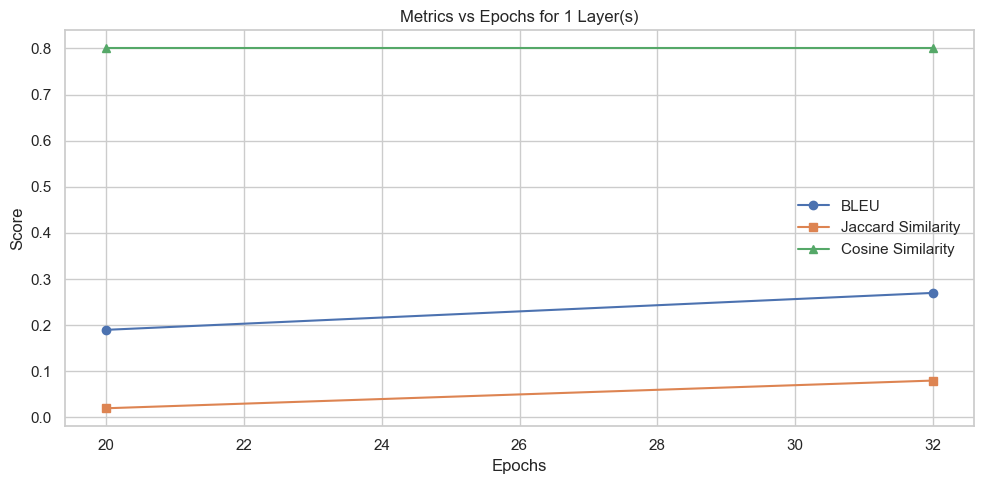


Metrics for Layer 2:
Dataset Epochs BLEU   Jaccard  Cosine
----------------------------------------
30k    30     0.247  0.070    0.610 
all    30     0.320  0.120    0.830 
30k    40     0.260  0.080    0.650 
30k    50     0.260  0.080    0.650 


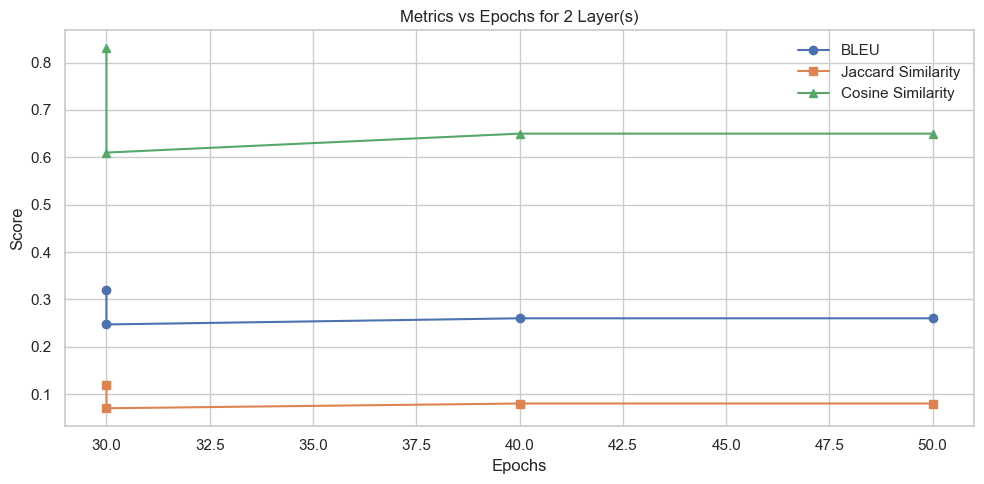


Metrics for Layer 3:
Dataset Epochs BLEU   Jaccard  Cosine
----------------------------------------
8k     20     0.220  0.060    0.600 
8k     52     0.270  0.100    0.800 


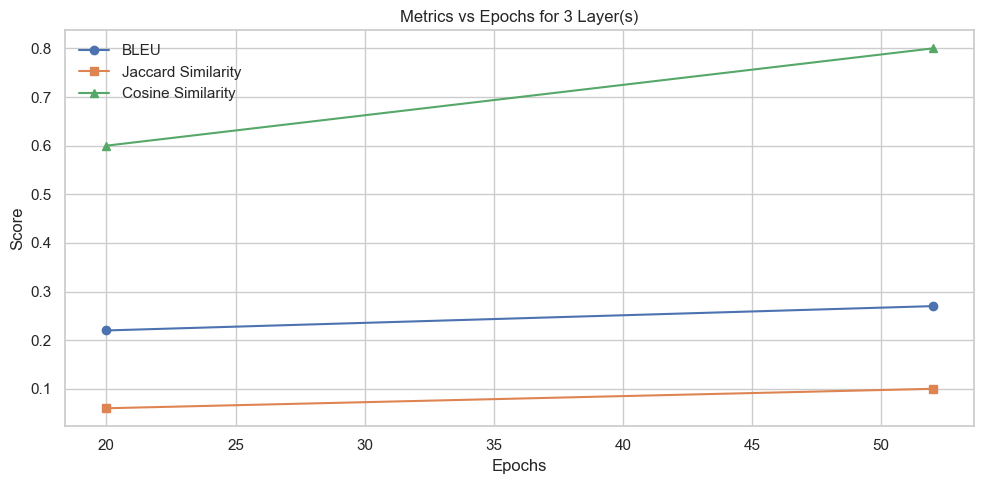

In [20]:
# import matplotlib.pyplot as plt

# # Data extracted from the image
# data = [
#     # [Dataset, Epochs, Layers, Bleu, Jaccard, Cosine]
#     ["30k", 50, 2, 0.26, 0.08, 0.65],
#     ["30k", 40, 2, 0.26, 0.08, 0.65],
#     ["30k", 30, 2, 0.247, 0.07, 0.61],
#     ["all", 30, 2, 0.31, 0.09, 0.81],
#     ["8k", 52, 3, 0.27, 0.1, 0.8],
#     ["8k", 20, 3, 0.22, 0.06, 0.6],
#     ["8k", 32, 1, 0.27, 0.08, 0.8],
#     ["8k", 20, 1, 0.19, 0.02, 0.8],
# ]

# # Group data by layer
# from collections import defaultdict
# layer_data = defaultdict(list)

# for entry in data:
#     dataset, epochs, layers, bleu, jaccard, cosine = entry
#     layer_data[layers].append((epochs, bleu, jaccard, cosine))

# # Plot for each layer
# for layer in sorted(layer_data.keys()):
#     epochs = [e[0] for e in layer_data[layer]]
#     bleu = [e[1] for e in layer_data[layer]]
#     jaccard = [e[2] for e in layer_data[layer]]
#     cosine = [e[3] for e in layer_data[layer]]

#     plt.figure(figsize=(10, 5))
#     plt.plot(epochs, bleu, marker='o', label='BLEU')
#     plt.plot(epochs, jaccard, marker='s', label='Jaccard Similarity')
#     plt.plot(epochs, cosine, marker='^', label='Cosine Similarity')
#     plt.title(f'Metrics vs Epochs for {layer} Layer(s)')
#     plt.xlabel('Epochs')
#     plt.ylabel('Score')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

import matplotlib.pyplot as plt
from collections import defaultdict

# Data extracted from the image
data = [
    # [Dataset, Epochs, Layers, Bleu, Jaccard, Cosine]
    ["30k", 50, 2, 0.26, 0.08, 0.65],
    ["30k", 40, 2, 0.26, 0.08, 0.65],
    ["30k", 30, 2, 0.247, 0.07, 0.61],
    ["all", 30, 2, 0.32, 0.12, 0.83],
    ["8k", 52, 3, 0.27, 0.1, 0.8],
    ["8k", 20, 3, 0.22, 0.06, 0.6],
    ["8k", 32, 1, 0.27, 0.08, 0.8],
    ["8k", 20, 1, 0.19, 0.02, 0.8],
]

# Group data by layer
layer_data = defaultdict(list)

for entry in data:
    dataset, epochs, layers, bleu, jaccard, cosine = entry
    layer_data[layers].append((dataset, epochs, bleu, jaccard, cosine))

# Print metrics and plot for each layer
for layer in sorted(layer_data.keys()):
    print(f"\nMetrics for Layer {layer}:")
    print(f"{'Dataset':<6} {'Epochs':<6} {'BLEU':<6} {'Jaccard':<8} {'Cosine':<6}")
    print("-" * 40)
    for d, e, b, j, c in sorted(layer_data[layer], key=lambda x: x[1]):
        print(f"{d:<6} {e:<6} {b:<6.3f} {j:<8.3f} {c:<6.3f}")
    
    # Extract values for plotting
    epochs = [e for (_, e, _, _, _) in layer_data[layer]]
    bleu = [b for (_, _, b, _, _) in layer_data[layer]]
    jaccard = [j for (_, _, _, j, _) in layer_data[layer]]
    cosine = [c for (_, _, _, _, c) in layer_data[layer]]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, bleu, marker='o', label='BLEU')
    plt.plot(epochs, jaccard, marker='s', label='Jaccard Similarity')
    plt.plot(epochs, cosine, marker='^', label='Cosine Similarity')
    plt.title(f'Metrics vs Epochs for {layer} Layer(s)')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Metrics for Stacked LSTM layer = 1:
Dataset Epochs BLEU   Jaccard  Cosine
----------------------------------------
8k     20     0.199  0.021    0.832 
8k     32     0.273  0.081    0.856 


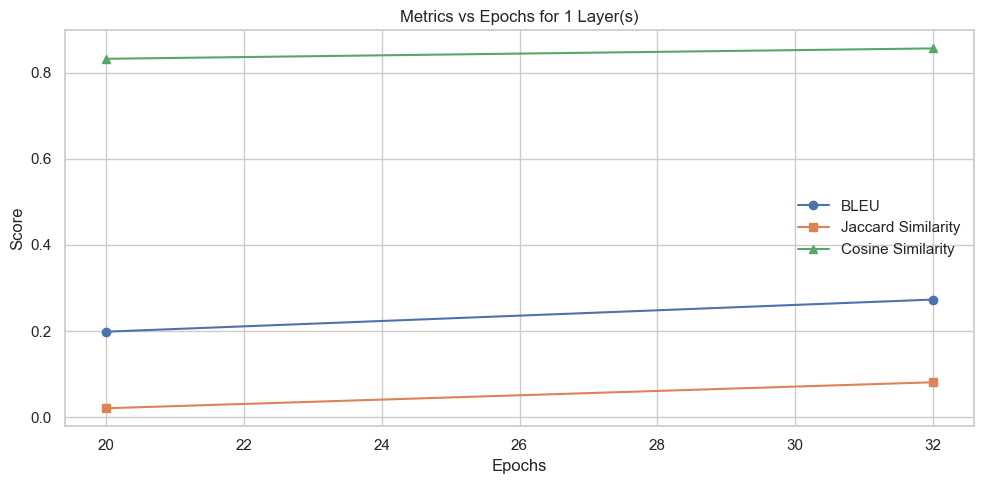


Metrics for Stacked LSTM layer = 2:
Dataset Epochs BLEU   Jaccard  Cosine
----------------------------------------
30k    30     0.247  0.077    0.613 
all    30     0.321  0.128    0.840 
30k    40     0.264  0.080    0.652 
30k    50     0.262  0.082    0.658 


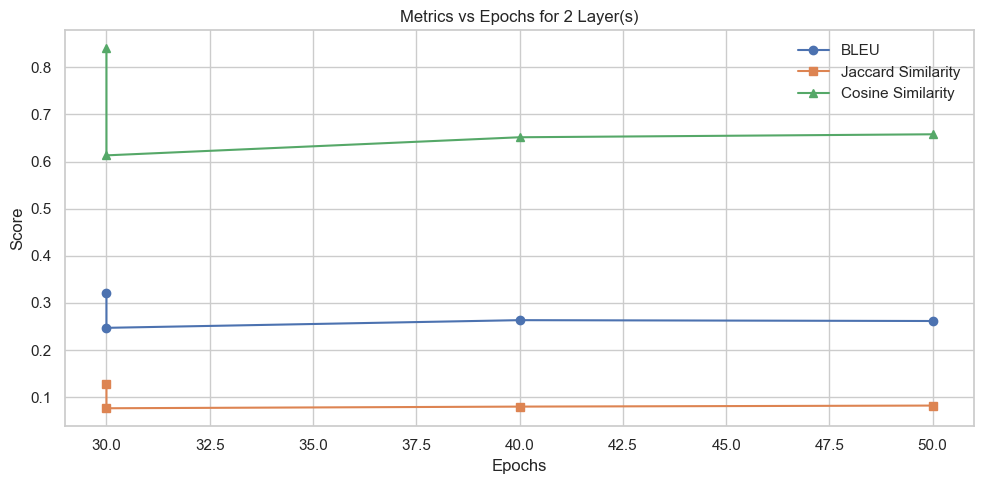


Metrics for Stacked LSTM layer = 3:
Dataset Epochs BLEU   Jaccard  Cosine
----------------------------------------
8k     20     0.228  0.067    0.698 
8k     52     0.279  0.103    0.830 


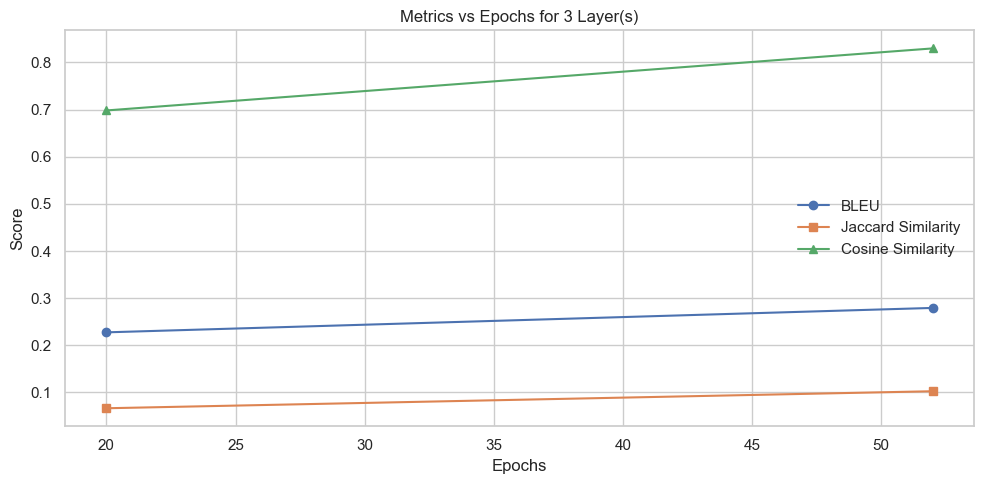


🔝 Best Overall Model:
Dataset: all
Epochs: 30
Layers: 2
BLEU Score: 0.3212
Jaccard Similarity: 0.1279
Cosine Similarity: 0.8401


In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Data extracted from the image
data = [
    # [Dataset, Epochs, Layers, Bleu, Jaccard, Cosine]
    ["30k", 50, 2, 0.2618, 0.0824, 0.6579],
    ["30k", 40, 2, 0.2636, 0.0802, 0.6516],
    ["30k", 30, 2, 0.2473, 0.0767, 0.6132],
    ["all", 30, 2, 0.3212, 0.1279, 0.8401],
    ["8k", 52, 3, 0.2793, 0.1026, 0.8297],
    ["8k", 20, 3, 0.2275, 0.0665, 0.6981],
    ["8k", 32, 1, 0.2732, 0.0813, 0.8561],
    ["8k", 20, 1, 0.1987, 0.021, 0.832],
]

# Group data by layer
layer_data = defaultdict(list)
best_model = None  # To store best model

for entry in data:
    dataset, epochs, layers, bleu, jaccard, cosine = entry
    layer_data[layers].append((dataset, epochs, bleu, jaccard, cosine))

    # Find best model (max BLEU, then Jaccard, then Cosine)
    if best_model is None:
        best_model = entry
    else:
        _, _, _, best_bleu, best_jaccard, best_cosine = best_model
        if (
            bleu > best_bleu or
            (bleu == best_bleu and jaccard > best_jaccard) or
            (bleu == best_bleu and jaccard == best_jaccard and cosine > best_cosine)
        ):
            best_model = entry


# Print metrics and plot for each layer
for layer in sorted(layer_data.keys()):
    print(f"\nMetrics for Stacked LSTM layer = {layer}:")
    print(f"{'Dataset':<6} {'Epochs':<6} {'BLEU':<6} {'Jaccard':<8} {'Cosine':<6}")
    print("-" * 40)
    for d, e, b, j, c in sorted(layer_data[layer], key=lambda x: x[1]):
        print(f"{d:<6} {e:<6} {b:<6.3f} {j:<8.3f} {c:<6.3f}")

    # Extract values for plotting
    epochs = [e for (_, e, _, _, _) in layer_data[layer]]
    bleu = [b for (_, _, b, _, _) in layer_data[layer]]
    jaccard = [j for (_, _, _, j, _) in layer_data[layer]]
    cosine = [c for (_, _, _, _, c) in layer_data[layer]]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, bleu, marker='o', label='BLEU')
    plt.plot(epochs, jaccard, marker='s', label='Jaccard Similarity')
    plt.plot(epochs, cosine, marker='^', label='Cosine Similarity')
    plt.title(f'Metrics vs Epochs for {layer} Layer(s)')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print best model overall
dataset, epochs, layers, bleu, jaccard, cosine = best_model
print("\n🔝 Best Overall Model:")
print(f"Dataset: {dataset}")
print(f"Epochs: {epochs}")
print(f"Layers: {layers}")
print(f"BLEU Score: {bleu}")
print(f"Jaccard Similarity: {jaccard}")
print(f"Cosine Similarity: {cosine}")
